In [ ]:
# Computing EOFs in 3D for 1x1 deg grid
# This is for all the depths up to 5500m 
# This calculation is ONLY the EOF calculation.

In [1]:
import numpy as np

from numpy import meshgrid
import scipy.io as sc
import os
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
from numpy import linspace
from numpy import meshgrid

## Reading in all the data

All data are in matlab files. This data is remote sensing data from JPL’s non-Boussinesq ocean general circulation model (OGCM). Remember to change to the appropriate directory to access each matlab file.

In [2]:
depths = [5, 10, 20, 30, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000]

In [3]:
#All Depths
depths = [5, 10, 20, 30, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000, 3000, 3500, 4000, 4500, 5000, 5500]

In [4]:
month = 'Dec'
start_num = 133

In [5]:
os.chdir(r'/Users/danilafarga/Desktop/SSS_Ocean/BIG_DATA/OGCM_1x1/'+month)

In [6]:
# putting all files into data directory
data = {}
for file in os.listdir():
    if ".mat" in file:
        data[file] = sc.loadmat(file)["data"][:,:,:]

In [7]:
# reformating data so that it is in order of depth long lat
data_T = np.empty((360*180*33,54)) * np.nan
for i in range(1950,2004):
    for j in range(33):
        data_T[360*180*j:360*180*(j+1), i-1950] = data[str(12*(i-1950)+ start_num)+  '_' +  month + '_' + str(i) +'_5m-5500m_1x1.mat'][:,:,j].flatten()
data_T = np.mat(data_T)

In [8]:
# shape should be N = 360(long) * 180(lat) * 33(depths) by 54 years
data_T.shape

(2138400, 54)

depths are defined based on matlab files. This calculation is in 3D so it will take into account every depth up to the limit set by the user. There are 33 depths in total. 

In [9]:
#need to get rid of the EOFs at depth of 40m
depth_index = 4
data_T  = np.delete(data_T, slice(64800 * depth_index, 64800 * (depth_index + 1)), axis = 0)
pprint(data_T.shape)

(2073600, 54)


In [10]:
# shortening the data so that it only has a specific amount of depths and not all depths 
tot_depths = 32

## Only if you need to shorten data

In [13]:
# Verifying the index is correct. Output should be 2000.
# Note since indexing starts at zero we subtract one from the total depths
depths[tot_depths-1]
# redifine data_T so it is shorter IF THAT IS WHAT WE NEED
data_T = data_T[0:360*180*tot_depths,:]

In [12]:
# shape should be N = 360(long) * 180(lat) * (depths) by 54 years

data_T.shape

(2073600, 54)

## Compute Standard Deviation and Climatology

In [11]:
N = data_T.shape[0] # total number of points
Y = data_T.shape[1] # total number of years

np.nanmean and np.nanstd computes the average and standard deviation for the rows (hence axis = 1) of the data. The command takes into account the NaNs for the data

In [12]:
import warnings

# I expect to see RuntimeWarnings in this block

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    clim = np.nanmean(data_T, axis = 1)   # climatology  
    sdev = np.nanstd(data_T, axis = 1)    # standard deviation
clim_sdev = np.column_stack((clim, sdev)) # save this as one matrix 

## Compute anomalies

Details of computing anomalies is in this post https://dlafarga.github.io/journal/python_start.html


In [13]:
anom = data_T - clim
anom.shape

(2073600, 54)

# Calc Standardized Anom

Standardized anomalies are anomalies divided by standard deviation

In [14]:
np.seterr(divide='ignore', invalid='ignore') # runtime error will appear because of truncation
stnd_anom = anom/sdev

## Compute area weighted Anom

Each Anom has to be multiplied by a weight to project data onto a physical surface. This weight takes into account lattitude and thickness of depth. 

In [15]:
import math

In [16]:
# lattitude values
x = linspace(-180, 180, 360)
y = linspace(-90, 90, 180)

xx, yy = meshgrid(x, y)

yy = yy.transpose()
y_temp = yy.flatten()

In [17]:
# area weight for lattitude values
area_w = np.cos(y_temp*math.pi/180)

In [18]:
# area weights for depth
area_weight = []

for i in range(tot_depths):
    #area_weight.append(area_w) # first depth thickness is just 0-5m
    if i == 0:
        area_weight.append(np.sqrt(5 * area_w)) # first depth thickness is just 0-5m
    else:
        area_weight.append( np.sqrt((depths[i] - depths[i - 1]) * area_w))

In [19]:
# Turning weights into one array
area_weight = np.mat(area_weight)
area_weight = area_weight.flatten()
area_weight = area_weight.transpose()
area_weight.shape

(2073600, 1)

In [20]:
weighted_A = np.empty((N,Y)) * np.nan
weighted_A = np.multiply(anom , area_weight)
weighted_A.shape

(2073600, 54)

##  Using EOF Solver

In [24]:
from eofs.standard import Eof

In [25]:
dat = np.array(weighted_A.T)

In [26]:
solver = Eof(dat)

In [27]:
eofs = solver.eofs()
eofs = eofs.T
eofs.shape

(2073600, 54)

In [28]:
eofs = eofs/area_weight[:,0]

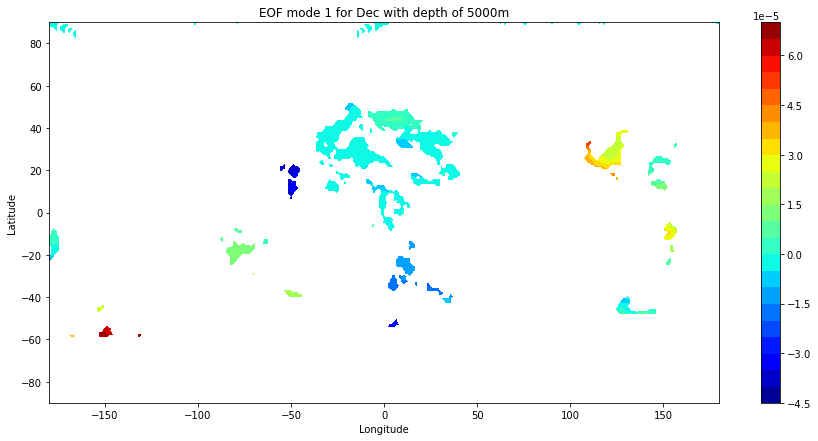

In [29]:
#Plot EOF
plt.figure(figsize=(15., 7.))

x = linspace(-180, 180, 360)
y = linspace(-90, 90, 180)

xx, yy = meshgrid(x, y)


mode = 0
depth_ind = 30
depth = depths[depth_ind]


EOF1 = np.reshape(eofs[depth_ind *64800: (depth_ind+1) *64800, mode],(360,180))
EOF1 = np.maximum(np.minimum(EOF1, .003), -.003)

plt.contourf(xx, yy, EOF1.transpose(), 25 ,cmap = 'jet')
plt.title('EOF mode '+ str(mode+1) + ' for '+month+' with depth of ' + str(depth) + 'm')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

plt.show()

In [30]:
pcs = solver.pcs()

In [31]:
# Normalize
for col_i in range(54):
    pcs[:,col_i] = pcs[:,col_i] / np.linalg.norm(pcs[:,col_i])

## Getting rid of NaN in anom

NaN needs to be removed from the data to compute covariance, eigenvalues, and eigenvectors

In [21]:
# find which indicies have data (are not NaN)
na_rows = np.argwhere(np.isnan(weighted_A) == False)
new_N = round(na_rows.shape[0]/54)

In [22]:
# Because entire rows have NaN the indicies are repeated for every column (Year)
# get rid of repeats to consolidate array which will give the row index without NaN
num_rows = []
count = 0
for i in range(new_N):
    num_rows.append(na_rows[i*Y,0])
numrows = np.array(num_rows)

In [23]:
# Create matrix with only values
new_anom = np.empty((new_N,Y)) * np.nan
for i in range(new_N):
        new_anom[i,:] = weighted_A[numrows[i],:]
new_anom = np.mat(new_anom)
new_anom.shape

(1060928, 54)

In [24]:
# how much of the data is data?
new_N/N

0.5116358024691358

## Compute Covariance

see https://dlafarga.github.io/journal/python_start.html for specifics on calculation

In [25]:
cov = (new_anom.T * new_anom)
# should have Y by Y matrix
cov.shape

(54, 54)

In [26]:
cov

matrix([[12479447.9737964 ,  8216532.8381861 ,  8286334.38409451, ...,
         -4016254.80059654, -3994895.5484381 , -4375501.15455184],
        [ 8216532.8381861 , 11522490.44915881,  8070364.44676579, ...,
         -4129553.98471214, -3551293.05694059, -3838524.69411873],
        [ 8286334.38409451,  8070364.44676579, 11417316.79527937, ...,
         -4303059.01087142, -3453052.61342406, -3892832.76290234],
        ...,
        [-4016254.80059654, -4129553.98471214, -4303059.01087142, ...,
          7062960.66268364,  2884105.35811014,  3438284.16373336],
        [-3994895.5484381 , -3551293.05694059, -3453052.61342406, ...,
          2884105.35811014,  9692944.25721008,  4951561.92572347],
        [-4375501.15455184, -3838524.69411873, -3892832.76290234, ...,
          3438284.16373336,  4951561.92572347,  8304272.93887467]])

## Computing Eigenvalues and Eigenvectors

see https://dlafarga.github.io/journal/python_start.html for specifics on calculation

important notes for np.linalg.eig:
    
    in  eigvals, eigvecs = np.linalg.eig(cov)
    The eigenvalues are not necessarily ordered
    the column eigves[:,i] is the eigenvector corresponding to the eigenvalue eigvals[i].

In [27]:
eigvals, eigvecs = np.linalg.eig(cov)

In [28]:
eigvecs = np.array(eigvecs)
eigvecs.shape

(54, 54)

In [29]:
# Check to make sure vectors are orthogonal
n, m = eigvecs.shape
for col_i in range(m):
    for col_j in range(m):
        if col_i < col_j:  # use strictly less than because we don't want to consider a column with itself, and the dot product is commutable so order doesn't matter
            is_orthogonal = np.dot(eigvecs[:, col_i], eigvecs[:, col_j])
            if not np.isclose(is_orthogonal, 0):
                raise ValueError(f"Eigenvector {col_i} and Eigenvector {col_j} are not orthogonal.")

In [30]:
# checking magnitude of EOF. If magnitude is not one error will be raised
for col_i in range(54):
    is_one = np.linalg.norm(eigvecs[:,col_i])
    if not np.isclose(is_one, 1):
        raise ValueError(f"EOF {col_i} is not one")

In [31]:
eigvecs = np.mat(eigvecs)

Sorting Eigenvalues and Eigenvectors

In [32]:
eig_index = np.argsort(eigvals)
eig_index = np.flip(eig_index)

In [33]:
new_eigvals = eigvals[eig_index[:]]
eigvals = new_eigvals

In [34]:
new_eigvecs = eigvecs[:,eig_index]
eigvecs = new_eigvecs 

NameError: name 'pcs' is not defined

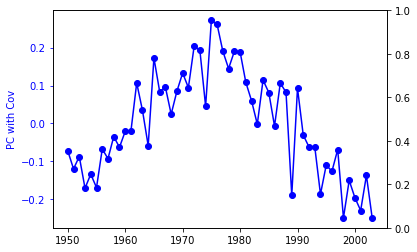

In [35]:
mode = 2
time = np.arange(1950,2004)

fig, ax = plt.subplots()

p1, = plt.plot(time, eigvecs[:,mode],'b', marker = 'o',label = 'PC with Cov')
ax.set_ylabel("PC with Cov")
ax.yaxis.label.set_color('blue')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()
p2, = plt.plot(time,pcs[:,mode],'r',marker = 'x',label = 'PC with SVD')
ax2.tick_params('y', colors='r')
ax2.set_ylabel("PC with SVD")
ax2.yaxis.label.set_color('red')

plt.legend(handles=[p1,p2],loc='center right')
plt.title('PC ' + str(mode+1)+' for '+month+' depths of 0m to ' + str(depths[tot_depths-1]) + 'm')
fig.set_size_inches(15., 7.)

#plt.savefig(r'/Volumes/Elements/'+month+'depth2000/imgs/PC_'+str(mode+1))


# Scree Plot

In [36]:
num_eval = np.arange(eigvals.shape[0])+1

In [37]:
cumulative_eval = np.cumsum(eigvals)

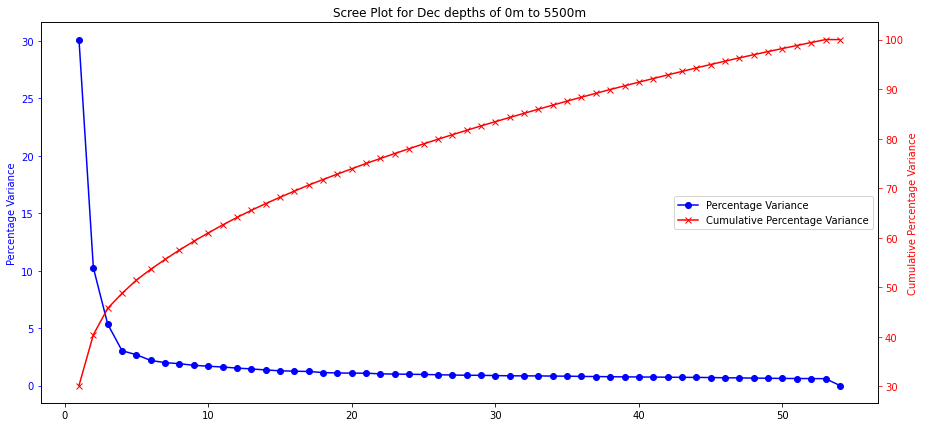

In [38]:
fig, ax = plt.subplots()


p1, = plt.plot(num_eval,(eigvals/cumulative_eval[-1])*100, 'b',marker = 'o',label = 'Percentage Variance')
ax.set_ylabel("Percentage Variance")
ax.yaxis.label.set_color('blue')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()
p2, = plt.plot(num_eval,(cumulative_eval/cumulative_eval[-1])*100,'r',marker = 'x',label = 'Cumulative Percentage Variance')
ax2.tick_params('y', colors='r')
ax2.set_ylabel("Cumulative Percentage Variance")
ax2.yaxis.label.set_color('red')

plt.legend(handles=[p1,p2],loc='center right')
plt.title('Scree Plot for '+month+' depths of 0m to ' + str(depths[tot_depths-1]) + 'm')
fig.set_size_inches(15., 7.)
#plt.savefig('/Users/danilafarga/Desktop/Thesis/3D_reconstruction/'+month+'/depth2000m/imgs/'+month+'_screePlot.png')

## Find EOF

see https://dlafarga.github.io/journal/python_start.html for specifics on calculation

### A*v

In [39]:
ev = eigvecs.T

In [40]:
EOFs = []
for j in range(Y):
    EOFs.append(np.matmul(weighted_A , ev[j].T))

In [41]:
EOF = np.array(EOFs)
EOF = np.squeeze(EOF)

In [42]:
EOF = EOF.T
EOF.shape

(2073600, 54)

### Getting rid of NaN

This is done to find magnitude of EOFs

In [43]:
na_rows = np.argwhere(np.isnan(EOF) == False)
new_N = round(na_rows.shape[0]/54)

In [44]:
new_EOF = np.empty((numrows.shape[0],Y))*np.nan
for i in range(numrows.shape[0]):
        new_EOF[i,:] = EOF[numrows[i],:]
new_EOF = np.mat(new_EOF)
new_EOF.shape

(1060928, 54)

### Find Magnitude and divide

In [45]:
mag = np.linalg.norm(new_EOF, axis = 0)

In [46]:
for i in range(Y):
    EOF[:,i] = EOF[:,i]/mag[i]

## Varifying Geometric EOFs

In [47]:
new_EOF = np.empty((numrows.shape[0],Y))*np.nan 
for i in range(numrows.shape[0]):
        new_EOF[i,:] = EOF[numrows[i],:]
new_EOF.shape

(1060928, 54)

In [48]:
# Check to make sure vectors are orthogonal
n, m = new_EOF.shape
for col_i in range(m):
    for col_j in range(m):
        if col_i < col_j:  # use strictly less than because we don't want to consider a column with itself, and the dot product is commutable so order doesn't matter
            is_orthogonal = np.dot(new_EOF[:, col_i], new_EOF[:, col_j])
            if not np.isclose(is_orthogonal, 0) and col_j != 53:
                pprint(f"EOF Mode {col_i} and EOF Mode {col_j} are not orthogonal.")
                pprint(np.dot(new_EOF[:, col_i], new_EOF[:, col_j]))
                

In [49]:
# checking magnitude of EOF. If magnitude is not one error will be raised
for col_i in range(54):
    is_one = np.linalg.norm(new_EOF[:,col_i])
    if not np.isclose(is_one, 1):
        raise ValueError(f"EOF {col_i} is not one")

In [50]:
# Printing magnitude of EOF. Each should be 1
for i in range (54):
    EOF1 = np.mat(EOF[:,i])
    nan_flag = np.isnan(EOF1)
    EOF1_clean = EOF1[~nan_flag]
    pprint(np.linalg.norm(EOF1_clean))

1.0000000000000173
1.0000000000000169
1.0000000000000264
0.9999999999999756
1.00000000000002
0.9999999999999927
1.0000000000000036
0.9999999999999906
1.0000000000000093
0.9999999999999858
0.9999999999999751
0.999999999999964
1.0000000000000098
0.9999999999999909
1.000000000000008
0.9999999999999578
0.9999999999999809
0.9999999999999848
1.0000000000000135
0.9999999999999838
1.000000000000003
0.9999999999999943
1.000000000000012
0.9999999999999885
1.0000000000000078
1.000000000000022
1.0000000000000173
1.00000000000002
0.9999999999999708
0.9999999999999929
1.0000000000000004
0.9999999999999752
0.9999999999999952
0.9999999999999961
0.999999999999995
0.9999999999999485
0.9999999999999855
1.0000000000000213
0.9999999999999527
1.0000000000000315
1.0000000000000167
1.0000000000000129
0.9999999999999887
1.0000000000000082
1.000000000000009
1.0000000000000049
0.9999999999999907
1.0000000000000016
1.0000000000000167
0.9999999999999865
0.9999999999999982
1.0000000000000044
1.0000000000000027
1.00

Now that  we have computed geometric EOFs we need to compute Physical EOFs by dividing by the volume weights. 

## Write NC files

## Saving Geometric EOFs 
#### these are the EOFs that ARE NOT divided by area weights

In [51]:
import netCDF4 as nc 
fn = '/Volumes/Elements/1deg_calc/All_EOFs_nc/depth_5500/geom_EOFs/geom_EOF_'+month+'_depth_5500.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

In [52]:
ds.createDimension('Z', 32)
ds.createDimension('Y', 180)
ds.createDimension('X', 360)
ds.createDimension('t', 54)
ds.createDimension('N', 2073600)

<class 'netCDF4._netCDF4.Dimension'>: name = 'N', size = 2073600

In [53]:
lon = ds.createVariable('lon', 'float32', ('X', 'Y'))
lat = ds.createVariable('lat', 'float32', ('X','Y'))
Z = ds.createVariable('Z', 'float32', 'Z')
EOFs = ds.createVariable('EOF', 'f4', ('N','t'))

In [54]:
x = linspace(-180, 180, 360)
y = linspace(-90, 90, 180)

xx, yy = meshgrid(x, y)

In [55]:
lon[:] = xx.T
lat[:] = yy.T
Z[:] = np.array(depths)
EOFs[:] = EOF
ds.close()

## Saving Physical EOFs 
#### these are the EOFs that ARE divided by area weights

In [78]:
EOF = EOF/area_weight[:,0]

In [ ]:
fn = '/Volumes/Elements/1deg_calc/All_EOFs_nc/depth_5500/phys_EOFs/phys_EOF_'+month+'_depth_5500.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

In [ ]:
ds.createDimension('Z', 32)
ds.createDimension('Y', 180)
ds.createDimension('X', 360)
ds.createDimension('t', 54)
ds.createDimension('N', 2073600)

In [ ]:
lon = ds.createVariable('lon', 'float32', ('X', 'Y'))
lat = ds.createVariable('lat', 'float32', ('X','Y'))
Z = ds.createVariable('Z', 'float32', 'Z')
EOFs = ds.createVariable('EOF', 'f4', ('N','t'))

In [ ]:
lon[:] = xx.T
lat[:] = yy.T
Z[:] = np.array(depths)
EOFs[:] = EOF
ds.close()

## Plot  Physical EOF

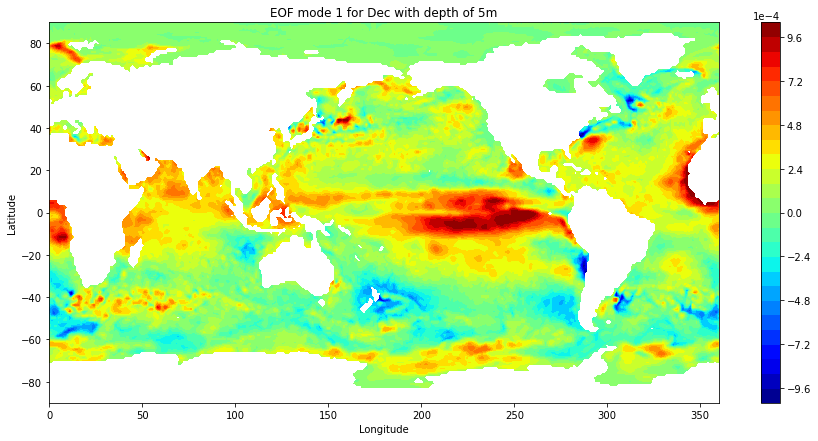

In [58]:
#Plot EOF
plt.figure(figsize=(15., 7.))

x = linspace(0, 360, 360)
y = linspace(-90, 90, 180)

xx, yy = meshgrid(x, y)


mode = 0
depth_ind = 0
depth = depths[depth_ind]


EOF1 = np.reshape(EOF[depth_ind *64800: (depth_ind+1) *64800, mode],(360,180))
EOF1 = np.maximum(np.minimum(EOF1, .001), -.001)

plt.contourf(xx, yy, EOF1.transpose(), 25 ,cmap = 'jet')
plt.title('EOF mode '+ str(mode+1) + ' for '+month+' with depth of ' + str(depth) + 'm')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

plt.show()

In [73]:
os.chdir(r'/Users/danilafarga/Desktop/Thesis/3D_reconstruction/')
np.savetxt('EOF_'+month+'_depth_'+ str(depths[tot_depths-1]) +'.txt',EOF)